<a href="https://colab.research.google.com/github/bonareri/Cryptocurrency-Price-Prediction-/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Understanding the Dataset

In [1]:
#Importing necesseray libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
import requests
import joblib
import math
import datetime as dt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# import keras_tuner as kt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
# Set the Seaborn style for all plots
sns.set_style("darkgrid")

In [22]:
# Define the coins and their tickers
COINS = {
    "bitcoin": "BTC-USD",
    "ethereum": "ETH-USD",
    "solana": "SOL-USD",
    "tether": "USDT-USD",  # Added USDT
    "xrp": "XRP-USD",      # Added XRP
    "binancecoin": "BNB-USD" # Added BNB
}

# Function to fetch historical price data
def fetch_crypto_data(coin_id, ticker):
    print(f"Fetching data for {coin_id.upper()}...")

    crypto = yf.Ticker(ticker)
    df = crypto.history(period="max")

    if df.empty:
        print(f"Error: No historical data found for {coin_id}.")
        return None

    # Format data
    df.reset_index(inplace=True)
    df["Date"] = pd.to_datetime(df["Date"]).dt.strftime('%Y-%m-%d')

    # Keep relevant columns
    df = df[["Date", "Close", "High", "Low", "Open", "Volume"]]

    return df

# Main function
def main():
    for coin_id, ticker in COINS.items():
        df = fetch_crypto_data(coin_id, ticker)
        if df is not None:
            filename = f"{coin_id}_prices.csv"
            df.to_csv(filename, index=False)
            print(f"Data saved to {filename}")

if __name__ == "__main__":
    main()


Fetching data for BITCOIN...
Data saved to bitcoin_prices.csv
Fetching data for ETHEREUM...
Data saved to ethereum_prices.csv
Fetching data for SOLANA...
Data saved to solana_prices.csv
Fetching data for TETHER...
Data saved to tether_prices.csv
Fetching data for XRP...
Data saved to xrp_prices.csv
Fetching data for BINANCECOIN...
Data saved to binancecoin_prices.csv


In [23]:
#List of Coins
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

#Dictionary to store dataframes
crypto_data = {}

#Load csv files dynamically
for coin in coins:
  filename = f"{coin}_prices.csv"
  crypto_data[coin] = pd.read_csv(filename)

In [24]:
for coin, df in crypto_data.items():
  print(f"\n First 5 rows of {coin.capitalize()} data:")
  print(df.head())


 First 5 rows of Bitcoin data:
         Date       Close        High         Low        Open    Volume
0  2014-09-17  457.334015  468.174011  452.421997  465.864014  21056800
1  2014-09-18  424.440002  456.859985  413.104004  456.859985  34483200
2  2014-09-19  394.795990  427.834991  384.532013  424.102997  37919700
3  2014-09-20  408.903992  423.295990  389.882996  394.673004  36863600
4  2014-09-21  398.821014  412.425995  393.181000  408.084991  26580100

 First 5 rows of Ethereum data:
         Date       Close        High         Low        Open      Volume
0  2017-11-09  320.884003  329.451996  307.056000  308.644989   893249984
1  2017-11-10  299.252991  324.717987  294.541992  320.670990   885985984
2  2017-11-11  314.681000  319.453003  298.191986  298.585999   842300992
3  2017-11-12  307.907990  319.153015  298.513000  314.690002  1613479936
4  2017-11-13  316.716003  328.415009  307.024994  307.024994  1041889984

 First 5 rows of Solana data:
         Date     Close     

In [25]:
for coin, df in crypto_data.items():
  print(f"\n Overview of {coin.capitalize()} data:")
  print(df.info())


 Overview of Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3834 entries, 0 to 3833
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    3834 non-null   object 
 1   Close   3834 non-null   float64
 2   High    3834 non-null   float64
 3   Low     3834 non-null   float64
 4   Open    3834 non-null   float64
 5   Volume  3834 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 179.8+ KB
None

 Overview of Ethereum data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2685 non-null   object 
 1   Close   2685 non-null   float64
 2   High    2685 non-null   float64
 3   Low     2685 non-null   float64
 4   Open    2685 non-null   float64
 5   Volume  2685 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 126.0+ KB
None



In [26]:
# Create a new dictionary to store cleaned data
cleaned_data = {}

for coin, df in crypto_data.items():
    # Convert 'Date' to datetime format
    df["Date"] = pd.to_datetime(df["Date"])

    # Set 'Date' as the index
    df.set_index("Date", inplace=True)

    # Store cleaned data in a new dictionary to avoid modifying while iterating
    cleaned_data[coin] = df

    # Print DataFrame info separately to avoid returning None
    print(f"\nCleaned {coin.capitalize()} data:")
    df.info()

# Assign the cleaned data back to the original dictionary
crypto_data = cleaned_data


Cleaned Bitcoin data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3834 entries, 2014-09-17 to 2025-03-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   3834 non-null   float64
 1   High    3834 non-null   float64
 2   Low     3834 non-null   float64
 3   Open    3834 non-null   float64
 4   Volume  3834 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 179.7 KB

Cleaned Ethereum data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2685 entries, 2017-11-09 to 2025-03-16
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   2685 non-null   float64
 1   High    2685 non-null   float64
 2   Low     2685 non-null   float64
 3   Open    2685 non-null   float64
 4   Volume  2685 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.9 KB

Cleaned Solana data:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1802 ent

## 2. Data Preprocessing

In [27]:
#Dictionary to store close price
crypto_close = {}

#Select only close for each coin
for coin, df in crypto_data.items():
  crypto_close[coin] = df["Close"]

In [28]:
for coin, df in crypto_close.items():
  print(f"\n First 5 rows of {coin.capitalize()} close prices:")
  print(df.head())


 First 5 rows of Bitcoin close prices:
Date
2014-09-17    457.334015
2014-09-18    424.440002
2014-09-19    394.795990
2014-09-20    408.903992
2014-09-21    398.821014
Name: Close, dtype: float64

 First 5 rows of Ethereum close prices:
Date
2017-11-09    320.884003
2017-11-10    299.252991
2017-11-11    314.681000
2017-11-12    307.907990
2017-11-13    316.716003
Name: Close, dtype: float64

 First 5 rows of Solana close prices:
Date
2020-04-10    0.951054
2020-04-11    0.776819
2020-04-12    0.882507
2020-04-13    0.777832
2020-04-14    0.661925
Name: Close, dtype: float64

 First 5 rows of Tether close prices:
Date
2017-11-09    1.00818
2017-11-10    1.00601
2017-11-11    1.00899
2017-11-12    1.01247
2017-11-13    1.00935
Name: Close, dtype: float64

 First 5 rows of Xrp close prices:
Date
2017-11-09    0.217488
2017-11-10    0.206483
2017-11-11    0.210430
2017-11-12    0.197339
2017-11-13    0.203442
Name: Close, dtype: float64

 First 5 rows of Binancecoin close prices:
Date
2

## Train Test Split

In [29]:
# Function to split data into 80% training and 20% testing
def split_data(df_close):
    train_size = int(len(df_close) * 0.8)  # 80% of data
    df_train = df_close[:train_size].values  # Training set
    df_test = df_close[train_size:].values   # Testing set
    return df_train, df_test

# Dictionary to store train and test sets for each cryptocurrency
train_test_data = {}

# Assuming crypto_closes is a dictionary where keys are coin names and values are Close price DataFrames
for coin, df_close in crypto_close.items():
    train, test = split_data(df_close)
    train_test_data[coin] = {"train": train, "test": test}

    # Print train-test split info
    print(f"{coin.capitalize()} - Train: {train.shape}, Test: {test.shape}")

Bitcoin - Train: (3067,), Test: (767,)
Ethereum - Train: (2148,), Test: (537,)
Solana - Train: (1441,), Test: (361,)
Tether - Train: (2148,), Test: (537,)
Xrp - Train: (2148,), Test: (537,)
Binancecoin - Train: (2148,), Test: (537,)


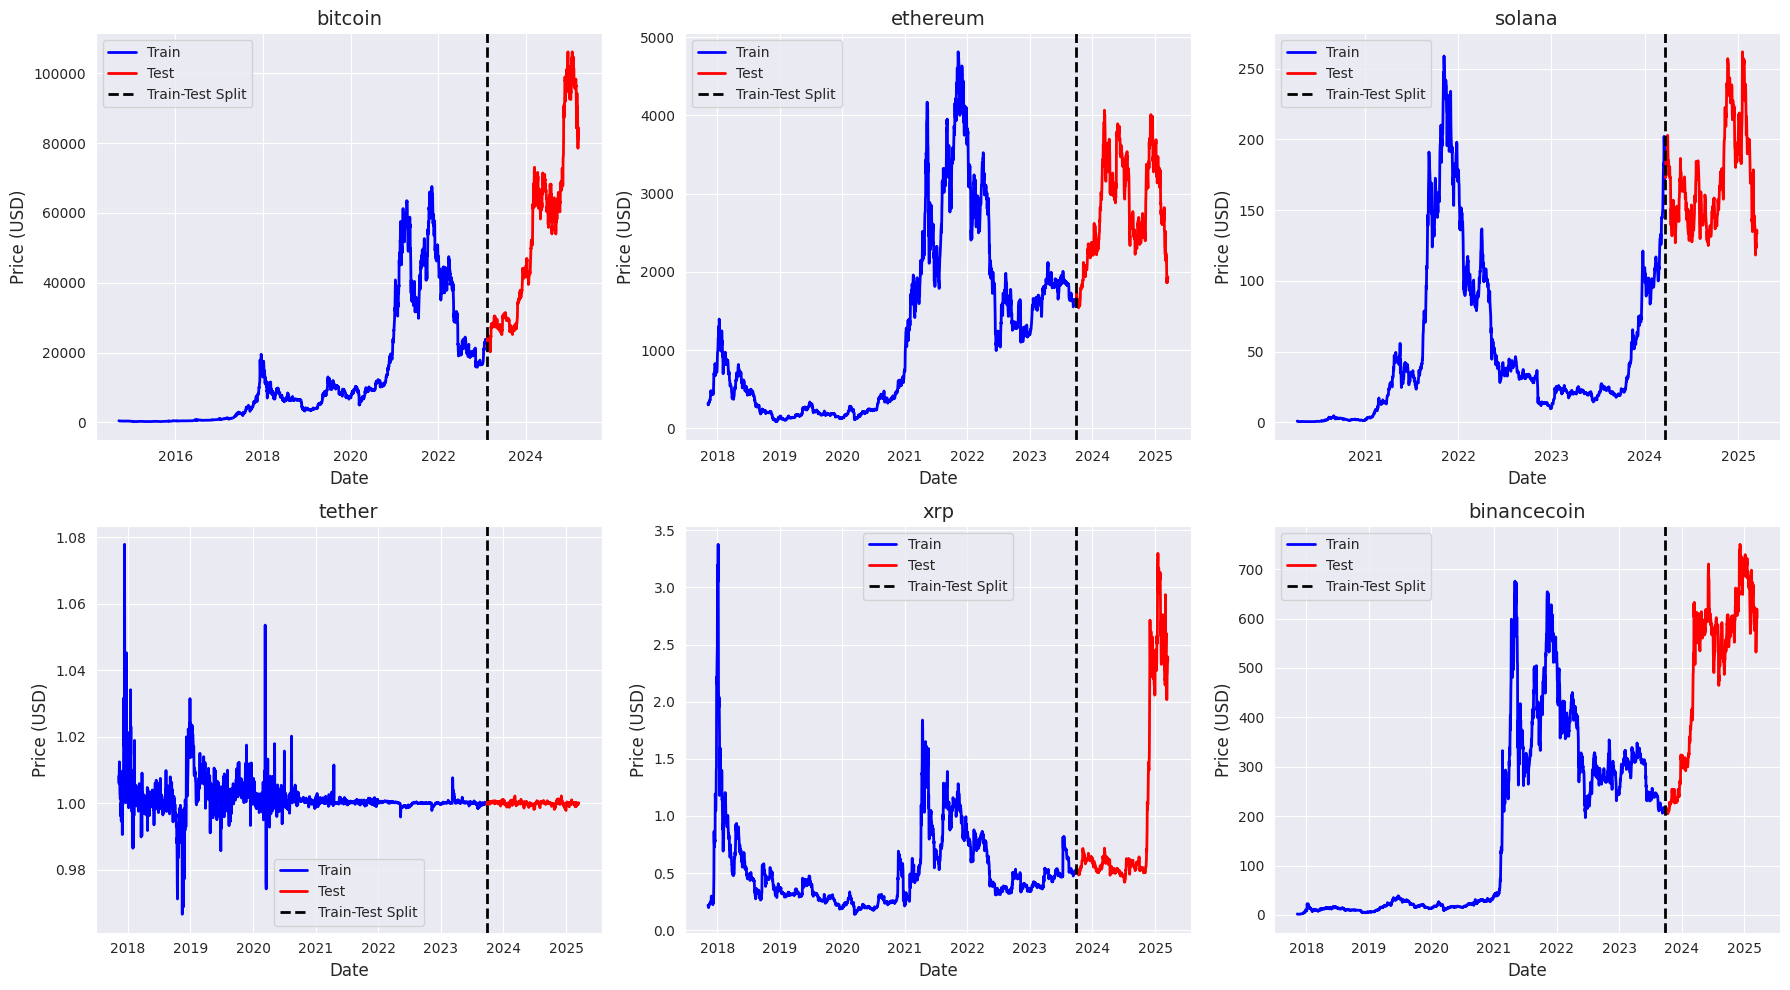

In [30]:
# Extract "Close" price column dynamically from the crypto_data dictionary
crypto_close_data = {coin: df["Close"] for coin, df in crypto_data.items()}

# Determine number of cryptocurrencies
num_coins = len(crypto_close_data)
rows, cols = 3, 3  # 3x3 grid

# Adjust grid if there are fewer than 9 cryptocurrencies
if num_coins < 9:
    rows = int(np.ceil(num_coins / cols))  # Adjust rows dynamically

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(6 * cols, 5 * rows), sharex=False)

# Flatten axes for easy iteration (handles cases where we have less than 9 plots)
axes = axes.flatten()

# Process and plot for each cryptocurrency
for ax, (coin_name, df) in zip(axes, crypto_close_data.items()):
    df_train, df_test = split_data(df)  # Split data
    train_size = len(df_train)  # Get split index

    # Plot training data
    ax.plot(df.index[:train_size], df_train, label='Train', linewidth=2, color='blue')

    # Plot test data
    ax.plot(df.index[train_size:], df_test, label='Test', linewidth=2, color='red')

    # Add vertical split line
    ax.axvline(df.index[train_size], color='black', linestyle='--', linewidth=2, label='Train-Test Split')

    # Set title
    ax.set_title(coin_name, fontsize=14)

    # Set y-label dynamically
    ax.set_ylabel('Price (USD)', fontsize=12)

    # Set x-label for all plots
    ax.set_xlabel('Date', fontsize=12)
    ax.legend(loc='best', fontsize=10)

# Hide any unused subplots (if less than 9 coins)
for i in range(num_coins, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Feature Scaling

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Min Max Scaling of Data post Train-Test Split </h3>
</div>

I ensured that scaling is done only after splitting the data into training and test sets, with each set being scaled separately.

Performing normalization on the data before splitting it is problematic because the scaling process would use the entire dataset — including the test set — as a reference.

This inadvertently causes data leakage from the test set into the training data, leading to unrealistic model performance and potential overfitting. By scaling only after the split, I ensured that the test set remained unseen and untouched during training, which is crucial for accurate model evaluation.










In [31]:
# Function to scale train and test data
def scale_data(train, test):
    scaler = MinMaxScaler(feature_range=(0, 1))  # Initialize a new scaler for each coin
    train = train.reshape(-1, 1)  # Ensure correct shape
    test = test.reshape(-1, 1)

    scaled_train = scaler.fit_transform(train)  # Fit on train, transform train
    scaled_test = scaler.transform(test)  # Transform test (without fitting again)

    return scaled_train, scaled_test, scaler  # Return scaler for potential inverse transformation

# Dictionary to store scaled data
scaled_crypto_data = {}

# Scale each cryptocurrency dataset dynamically
for coin, df_close in crypto_close_data.items():
    train, test = split_data(df_close)  # Split train & test
    scaled_train, scaled_test, scaler = scale_data(train, test)  # Scale data

    scaled_crypto_data[coin] = {
        "train": scaled_train,
        "test": scaled_test,
        "scaler": scaler  # Store scaler for later inverse transforms if needed
    }

# Print shapes and min-max values for confirmation
for coin, data in scaled_crypto_data.items():
    train, test = data["train"], data["test"]
    print(f"{coin} - Scaled Train Shape: {train.shape}, Min: {train.min():.4f}, Max: {train.max():.4f}")
    print(f"{coin} - Scaled Test Shape: {test.shape}, Min: {test.min():.4f}, Max: {test.max():.4f}")
    print("-" * 50)

bitcoin - Scaled Train Shape: (3067, 1), Min: 0.0000, Max: 1.0000
bitcoin - Scaled Test Shape: (767, 1), Min: 0.2969, Max: 1.5725
--------------------------------------------------
ethereum - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
ethereum - Scaled Test Shape: (537, 1), Min: 0.3078, Max: 0.8423
--------------------------------------------------
solana - Scaled Train Shape: (1441, 1), Min: 0.0000, Max: 1.0000
solana - Scaled Test Shape: (361, 1), Min: 0.4558, Max: 1.0114
--------------------------------------------------
tether - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
tether - Scaled Test Shape: (537, 1), Min: 0.2805, Max: 0.3199
--------------------------------------------------
xrp - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
xrp - Scaled Test Shape: (537, 1), Min: 0.0865, Max: 0.9755
--------------------------------------------------
binancecoin - Scaled Train Shape: (2148, 1), Min: 0.0000, Max: 1.0000
binancecoin - Scaled Test Shape: (5

In [32]:
# Save scalers dynamically for all cryptocurrencies
for coin, data in scaled_crypto_data.items():
    scaler_filename = f"{coin.lower()}_scaler.pkl"  # Convert coin name to lowercase for filename
    joblib.dump(data["scaler"], scaler_filename)  # Save scaler
    print(f"Scaler saved successfully for {coin}: {scaler_filename}")

Scaler saved successfully for bitcoin: bitcoin_scaler.pkl
Scaler saved successfully for ethereum: ethereum_scaler.pkl
Scaler saved successfully for solana: solana_scaler.pkl
Scaler saved successfully for tether: tether_scaler.pkl
Scaler saved successfully for xrp: xrp_scaler.pkl
Scaler saved successfully for binancecoin: binancecoin_scaler.pkl


<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> Time Series Windowing (Sequence Generation) </h3>
</div>

Since I’m working with **time series data**, I need the LSTM model to learn from **sequential patterns** instead of treating each data point independently.  

Time series windowing transforms raw time series data into **input-output pairs** so that the model can learn from historical data and make accurate future predictions.  

---

**Steps I Took**  

**1️⃣ Defined a Look-Back Window (Sliding Window)**  
I set a **look-back period** (`look_back = 5`), meaning the model will use the **past 5 days' prices** to predict the **next day's price**.  
This helps capture short-term trends in the data.

 Example:  


For example, given a sequence like [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], the data will be split into samples like:

```python

Input 				| Output
1, 2, 3, 4, 5 		6
2, 3, 4, 5, 6 		7
3, 4, 5, 6, 7 		8

```
**2️⃣ Created Input (X) and Output (y) Pairs**  
I looped through the **scaled dataset** and extracted:  
- **X** → The past `look_back` days (input sequence).  
- **y** → The next day's value (target label).  



In [33]:
import numpy as np

# Function to create LSTM sequences
def create_sequences(dataset, look_back=5):
    """
    Generates input-output pairs for LSTM.

    Args:
        dataset (numpy.ndarray): Scaled dataset.
        look_back (int): Number of previous timesteps used for prediction.

    Returns:
        tuple: Feature sequences (X) and target values (y).
    """
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])  # Past `look_back` values
        y.append(dataset[i + look_back, 0])  # The next value (target)

    return np.array(X).reshape(-1, look_back, 1), np.array(y)  # ✅ Ensure correct shape

# Define look_back period (e.g., 5 days)
look_back = 5

# Dictionary to store sequences for each cryptocurrency
train_sequences, test_sequences = {}, {}

# Process each cryptocurrency dynamically
for coin, data in scaled_crypto_data.items():
    train_sequences[coin] = create_sequences(data["train"], look_back)
    test_sequences[coin] = create_sequences(data["test"], look_back)

# Extract sequences dynamically
for coin, (trainX, trainY) in train_sequences.items():
    testX, testY = test_sequences[coin]

    print(f"{coin} - TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
    print(f"{coin} - TestX shape: {testX.shape}, TestY shape: {testY.shape}")
    print("-" * 50)

bitcoin - TrainX shape: (3062, 5, 1), TrainY shape: (3062,)
bitcoin - TestX shape: (762, 5, 1), TestY shape: (762,)
--------------------------------------------------
ethereum - TrainX shape: (2143, 5, 1), TrainY shape: (2143,)
ethereum - TestX shape: (532, 5, 1), TestY shape: (532,)
--------------------------------------------------
solana - TrainX shape: (1436, 5, 1), TrainY shape: (1436,)
solana - TestX shape: (356, 5, 1), TestY shape: (356,)
--------------------------------------------------
tether - TrainX shape: (2143, 5, 1), TrainY shape: (2143,)
tether - TestX shape: (532, 5, 1), TestY shape: (532,)
--------------------------------------------------
xrp - TrainX shape: (2143, 5, 1), TrainY shape: (2143,)
xrp - TestX shape: (532, 5, 1), TestY shape: (532,)
--------------------------------------------------
binancecoin - TrainX shape: (2143, 5, 1), TrainY shape: (2143,)
binancecoin - TestX shape: (532, 5, 1), TestY shape: (532,)
--------------------------------------------------


### Reshaping Data (LSTM Format)

- Convert trainX & testX into (samples, time steps, features) format for LSTM.
- **Samples**: The total number of data points (`len(dataX)`).
- **Time steps**: The width of the sliding window (e.g., 5 in this case).
- **Features**: The number of features per time step. For example, in predicting Bitcoin price, the feature is 1 (the price at that time step).
- LSTM expects 3D inputs.

---

<div style="background: linear-gradient(45deg, #FFC300, #FF5733, #C70039, #900C3F); padding: 10px; border-radius: 5px; display: flex; align-items: center;">
    <h3 style="font-weight: bold; color: white; margin: 0 auto;"> LSTM (Long Short-Term Memory) Mechanism </h3>
</div>

LSTM is a type of recurrent neural network (RNN) designed to overcome the vanishing gradient problem. It uses internal gates to regulate information flow, enabling effective backpropagation through time (BPTT).

#### LSTM Layers in Keras
- LSTM layers can be created using the `LSTM()` class in Keras.
- Each LSTM cell has an internal **cell state** (`c`) and a **hidden state** (`h`).
- The `input_shape` for LSTM is `(timesteps, n_features)`, e.g., `(95000, 360)`.
- Keras LSTM expects inputs in the shape: `(n_examples, n_timesteps, n_features)`.

#### `return_sequences=True`
- Enables stacking of multiple LSTM layers.
- Ensures the second LSTM layer receives a compatible n-dimensional sequence input.
- Outputs one value per time step when set to `True`.

#### Why Increase LSTM Depth?
- **Enhances feature abstraction**: Similar to deep learning, deeper LSTMs recombine learned representations to capture complex patterns.
- **Efficient training**: Deeper networks often require fewer neurons and train faster.
- **Temporal abstraction**: Stacking LSTM layers allows models to process sequences at different time scales.

Stacked LSTMs have become a standard approach for complex sequence prediction tasks.


In [34]:
# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Function to build an LSTM model
def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(units=50, return_sequences=True, activation='tanh',
             kernel_regularizer=l2(0.001), input_shape=input_shape),
        Dropout(0.3),  # Increased dropout

        LSTM(units=40, return_sequences=False, activation='tanh',
             kernel_regularizer=l2(0.001)),
        Dropout(0.3),

        Dense(units=30, activation='relu'),
        Dense(units=1)  # Output layer (linear activation for regression)
    ])

    # Compile the model with a lower learning rate
    model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error')

    return model

# Dictionary to store trained models and training history
models, histories = {}, {}

# Train a model for each cryptocurrency dynamically
for coin, (trainX, trainY) in reshaped_train_sequences.items():
    testX, testY = reshaped_test_sequences[coin]

    print(f"\n🚀 Training LSTM Model for {coin}...\n")

    # Build model
    model = build_lstm_model(input_shape=(trainX.shape[1], 1))

    # Train model
    history = model.fit(
        trainX, trainY,
        epochs=100,
        batch_size=64,  # Increased batch size
        validation_data=(testX, testY),
        callbacks=[early_stopping],
        verbose=1
    )

    # Store the trained model and training history
    models[coin] = model
    histories[coin] = history

    print(f"\n✅ Finished training {coin} model.\n" + "-" * 50)


🚀 Training LSTM Model for bitcoin...

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.1435 - val_loss: 0.1122
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0591 - val_loss: 0.0415
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0385 - val_loss: 0.0299
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0273 - val_loss: 0.0221
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0192 - val_loss: 0.0168
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0141 - val_loss: 0.0119
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0110 - val_loss: 0.0098
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0083 - val_loss: 0.0084
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0069 - val_loss: 0.0064
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0055 - val_loss: 0.0070
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0045 - val_loss: 0.0062
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0043 - val_

In [35]:
# Print model summaries for each cryptocurrency
print("\n🔍 Model Summaries for All Cryptocurrencies:\n" + "=" * 60)

for coin, model in models.items():
    print(f"\n📌 Model Summary for {coin}:\n" + "-" * 50)
    model.summary()
    print("-" * 50)


🔍 Model Summaries for All Cryptocurrencies:

📌 Model Summary for bitcoin:
--------------------------------------------------


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_13 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

📌 Model Summary for ethereum:
--------------------------------------------------


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_15 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

📌 Model Summary for solana:
--------------------------------------------------


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

📌 Model Summary for tether:
--------------------------------------------------


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_18 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_19 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

📌 Model Summary for xrp:
--------------------------------------------------


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_20 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_20 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_21 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------

📌 Model Summary for binancecoin:
--------------------------------------------------


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_22 (LSTM)                       │ (None, 5, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 5, 50)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_23 (LSTM)                       │ (None, 40)                  │          14,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 30)                  │           1,230 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              31 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 78,665 (307.29 KB)

 Trainable params: 26,221 (102.43 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 52,444 (204.86 KB)

--------------------------------------------------


In [36]:
# Save trained models for each cryptocurrency
print("\n💾 Saving Trained LSTM Models...\n" + "=" * 60)

for coin, model in models.items():
    model_filename = f"{coin.lower()}_lstm_model.keras"
    model.save(model_filename)
    print(f" {coin} LSTM model saved successfully as '{model_filename}'.")

print("\n🎉 All models saved successfully!\n" + "=" * 60)


💾 Saving Trained LSTM Models...
 bitcoin LSTM model saved successfully as 'bitcoin_lstm_model.keras'.
 ethereum LSTM model saved successfully as 'ethereum_lstm_model.keras'.
 solana LSTM model saved successfully as 'solana_lstm_model.keras'.
 tether LSTM model saved successfully as 'tether_lstm_model.keras'.
 xrp LSTM model saved successfully as 'xrp_lstm_model.keras'.
 binancecoin LSTM model saved successfully as 'binancecoin_lstm_model.keras'.

🎉 All models saved successfully!


## Model Evaluation

### Evaluate Model on Test Data

In [38]:
# Evaluate each model's performance on its respective test data
print("\n Evaluating Model Performance...\n" + "=" * 60)

evaluation_results = {}

for coin, model in models.items():
    testX, testY = test_sequences[coin]  # Get test data for the coin

    # Ensure testX has the correct shape (samples, timesteps, features)
    if len(testX.shape) == 2:  # (samples, timesteps) → missing features dimension
        testX = testX.reshape(testX.shape[0], testX.shape[1], 1)

    print(f"\n🔍 Evaluating {coin} model on test data...\n")
    test_loss = model.evaluate(testX, testY, verbose=1)

    evaluation_results[coin] = test_loss  # Store results for later reference
    print(f" {coin} Test Loss (MSE): {test_loss:.6f}\n" + "-" * 50)

# Display final summary of test losses
print("\n📈 Final Test Loss Summary:")
for coin, loss in evaluation_results.items():
    print(f"🔹 {coin}: {loss:.6f}")

print("\n Model evaluation completed!\n" + "=" * 60)


 Evaluating Model Performance...

🔍 Evaluating bitcoin model on test data...

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014
 bitcoin Test Loss (MSE): 0.002452
--------------------------------------------------

🔍 Evaluating ethereum model on test data...

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0014     
 ethereum Test Loss (MSE): 0.001788
--------------------------------------------------

🔍 Evaluating solana model on test data...

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0029
 solana Test Loss (MSE): 0.003488
--------------------------------------------------

🔍 Evaluating tether model on test data...

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.5666e-04 
 tether Test Loss (MSE): 0.000161
--------------------------------------------------

🔍 Evaluating xrp model on test data...

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0016 
 xrp Test Loss (MSE): 0.003127
--------------------------------------------------

🔍 Evaluating binancecoin model on test 

### Plot Training & Validation Loss Curves

In [40]:
print(histories.keys())

dict_keys(['bitcoin', 'ethereum', 'solana', 'tether', 'xrp', 'binancecoin'])


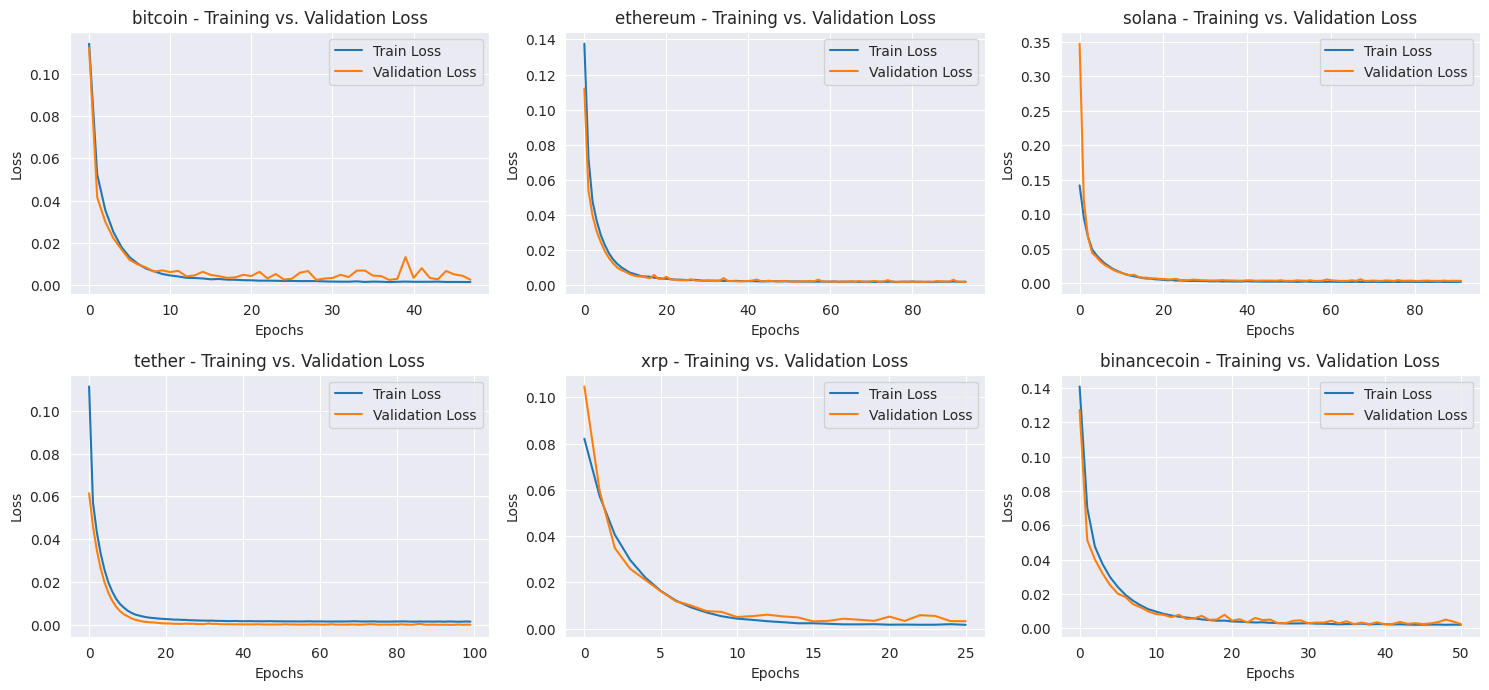

In [41]:
# List of cryptocurrencies to plot
coins = ['bitcoin', 'ethereum', 'solana', 'tether', 'xrp', 'binancecoin']

# Determine subplot grid size
rows, cols = 3, 3  # 3 rows, 3 columns

plt.figure(figsize=(15, 10))  # Adjust figure size for better visibility

for i, coin in enumerate(coins, 1):
    plt.subplot(rows, cols, i)  # Arrange subplots in a 3x3 grid
    plt.plot(histories[coin].history['loss'], label='Train Loss')
    plt.plot(histories[coin].history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{coin} - Training vs. Validation Loss')
    plt.legend()

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

### Generate Predictions & Inverse Transform

In [42]:
import joblib

# Define all cryptocurrency names in lowercase (matching test_sequences)
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

# Load saved scalers dynamically
scalers = {coin: joblib.load(f"{coin}_scaler.pkl") for coin in coins}

# Dictionary to store actual and predicted values
predictions = {}
actual_values = {}

# Predict and inverse transform for each coin
for coin in coins:
    model = models[coin]  # Access trained model for each coin
    scaler = scalers[coin]  # Access corresponding scaler

    # Predict using the respective model
    predicted = model.predict(test_sequences[coin][0])  # testX

    # Inverse transform predictions and actual values
    predictions[coin] = scaler.inverse_transform(predicted)
    actual_values[coin] = scaler.inverse_transform(test_sequences[coin][1].reshape(-1, 1))  # testY

    print(f"{coin.capitalize()} - Predictions Shape: {predictions[coin].shape}, Actual Shape: {actual_values[coin].shape}")


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Bitcoin - Predictions Shape: (762, 1), Actual Shape: (762, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Ethereum - Predictions Shape: (532, 1), Actual Shape: (532, 1)
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Solana - Predictions Shape: (356, 1), Actual Shape: (356, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Tether - Predictions Shape: (532, 1), Actual Shape: (532, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Xrp - Predictions Shape: (532, 1), Actual Shape: (532, 1)
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Binancecoin - Predictions Shape: (532, 1), Actual Shape: (532, 1)


### Performance Metrics (RMSE & MAE)

In [43]:
# Function to evaluate the model
def evaluate_model(actual, predicted, coin_name):
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)

    print(f" Model Evaluation for {coin_name.capitalize()}:")
    print(f"➡️ Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"➡️ Mean Absolute Error (MAE): {mae:.4f}")
    print("-" * 50)

# Define all cryptocurrencies
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

# Evaluate models for each cryptocurrency
for coin in coins:
    evaluate_model(actual_values[coin], predictions[coin], coin)

 Model Evaluation for Bitcoin:
➡️ Root Mean Squared Error (RMSE): 3024.1282
➡️ Mean Absolute Error (MAE): 2186.1358
--------------------------------------------------
 Model Evaluation for Ethereum:
➡️ Root Mean Squared Error (RMSE): 180.7998
➡️ Mean Absolute Error (MAE): 132.2961
--------------------------------------------------
 Model Evaluation for Solana:
➡️ Root Mean Squared Error (RMSE): 14.2042
➡️ Mean Absolute Error (MAE): 10.8128
--------------------------------------------------
 Model Evaluation for Tether:
➡️ Root Mean Squared Error (RMSE): 0.0005
➡️ Mean Absolute Error (MAE): 0.0004
--------------------------------------------------
 Model Evaluation for Xrp:
➡️ Root Mean Squared Error (RMSE): 0.1507
➡️ Mean Absolute Error (MAE): 0.0767
--------------------------------------------------
 Model Evaluation for Binancecoin:
➡️ Root Mean Squared Error (RMSE): 28.6134
➡️ Mean Absolute Error (MAE): 20.1773
--------------------------------------------------


### Plot Actual vs. Predicted Values

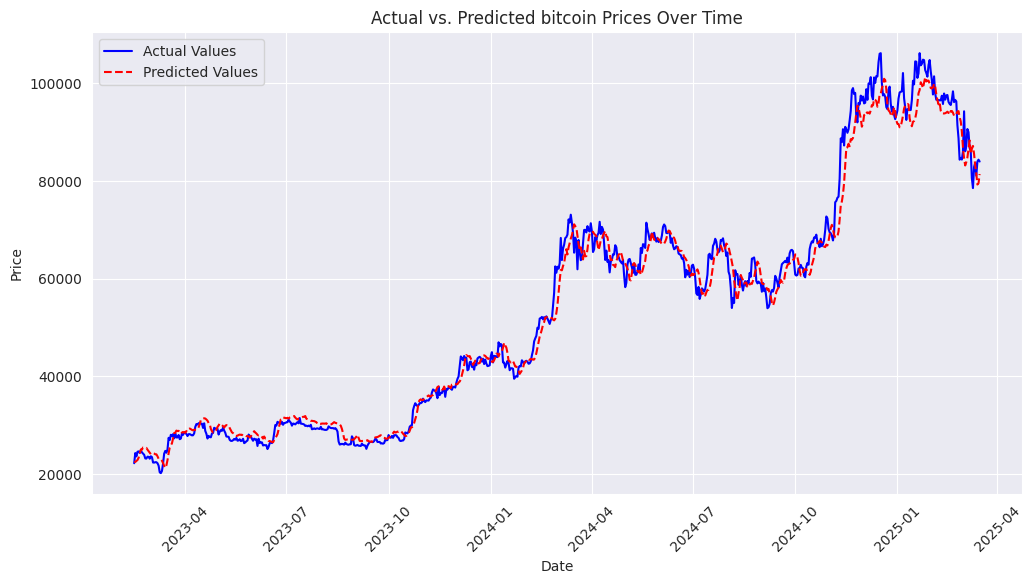

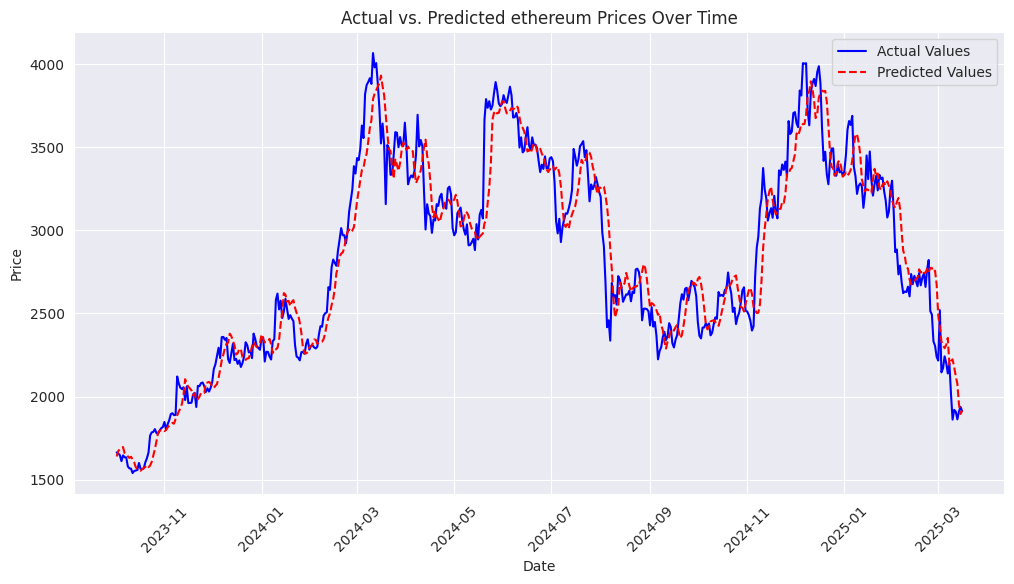

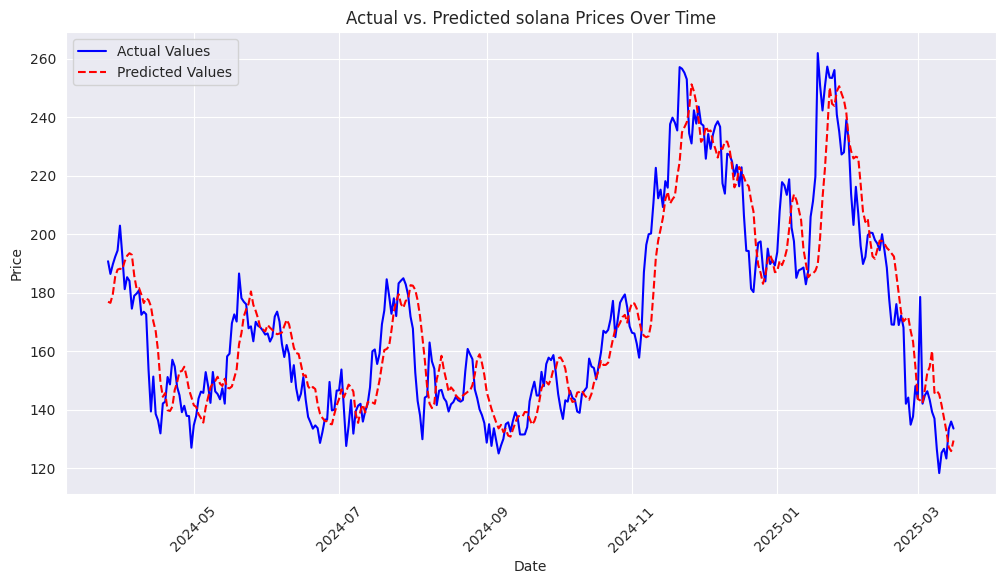

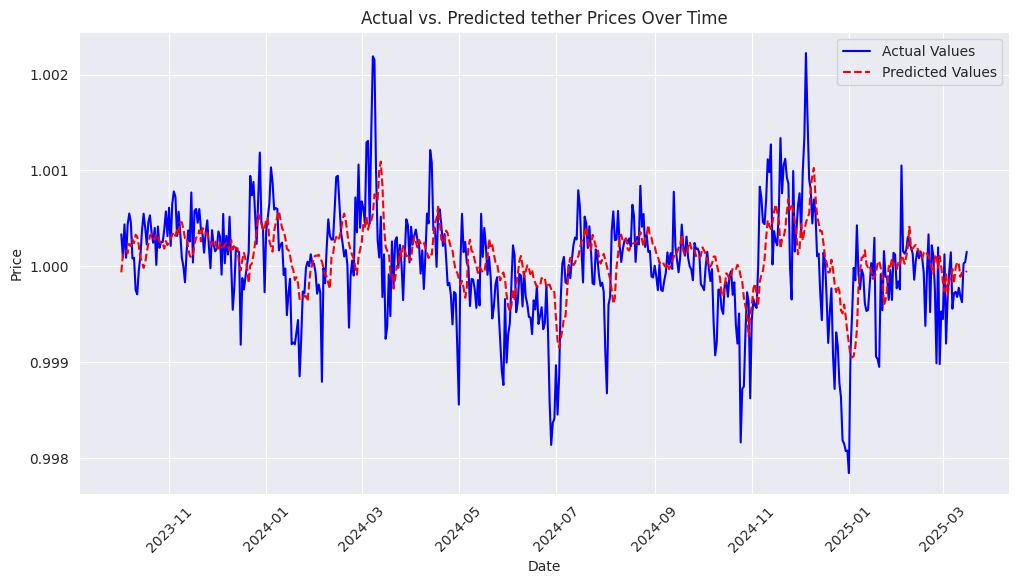

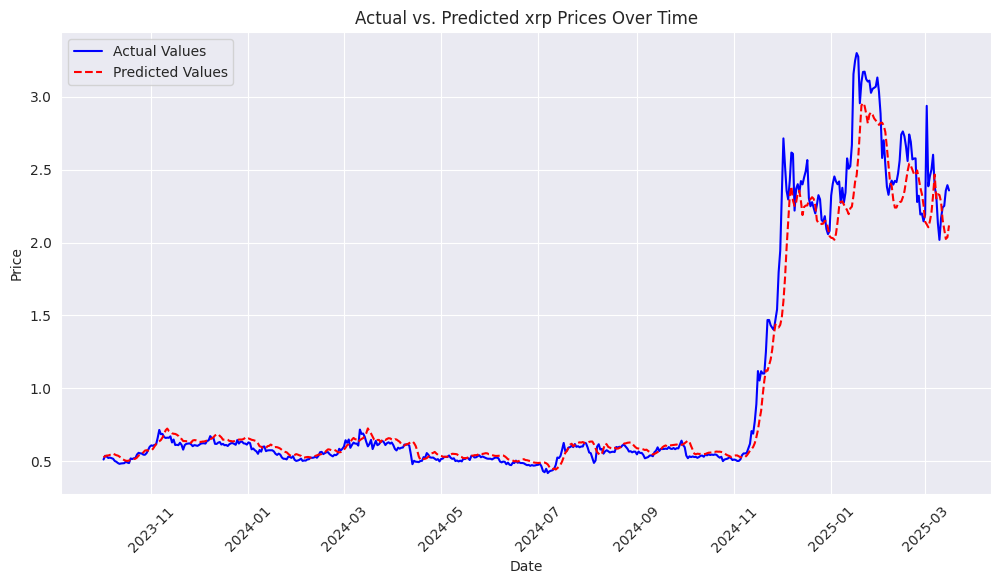

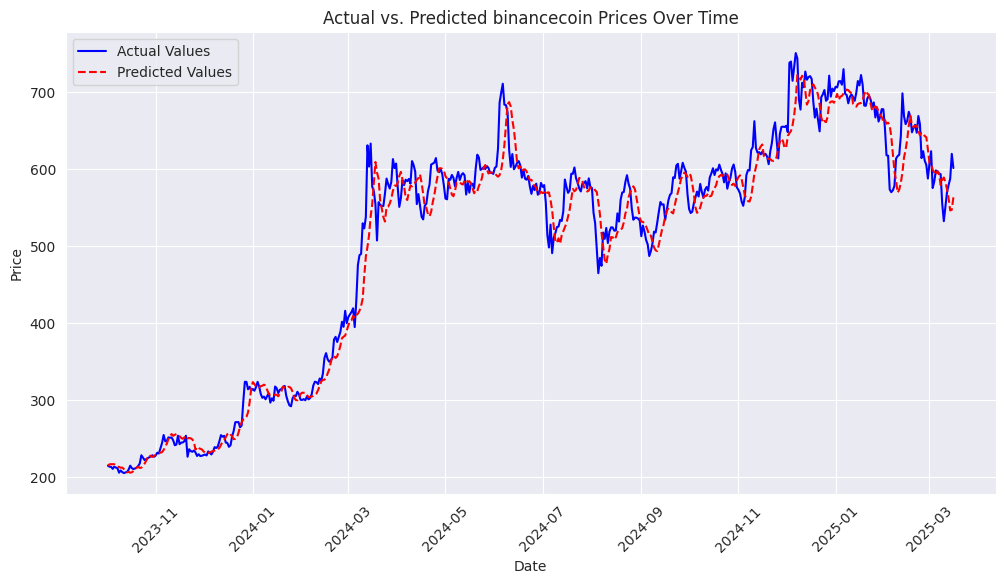

In [46]:
coins = ["bitcoin", "ethereum", "solana", "tether", "xrp", "binancecoin"]

# Plot actual vs. predicted values for each cryptocurrency
for coin in coins:
    plt.figure(figsize=(12, 6))

    # Get actual and predicted values
    actual = actual_values[coin]
    predicted = predictions[coin]

    # Get corresponding date indexes
    dates = crypto_close[coin].index

    # Plot actual values
    plt.plot(dates[-len(actual):], actual,
             label="Actual Values", color='blue', linestyle='solid')

    # Plot predicted values
    plt.plot(dates[-len(predicted):], predicted,
             label="Predicted Values", color='red', linestyle='dashed')

    # Graph labels
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title(f"Actual vs. Predicted {coin} Prices Over Time")
    plt.legend()
    plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility

    # Show the plot
    plt.show()